# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 


flopy is installed in c:\users\jakey\appdata\local\programs\python\python38-32\lib\site-packages\flopy


## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('top_elev.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction
#print(dz)

## Subsurface properties
   
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET_1 = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET_1 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (23.0, 29.0)  #forced riparian area
rip_cols_forced = (0.0, 50.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (0.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (0.0, 15.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
rech_zone=np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

# ## Well1: 
# pumping1 = 1500 #m3/day 
# well1_xy= [38000, 29000] #xy location of well 
# well1_row = np.floor((nrow)-(well1_xy[1]/dy)) #convert the y location to a row
# well1_col=np.floor(well1_xy[0]/dx) #convert the x location to a column
# well1_loc = (2,well1_row, well1_col) #Well loc shoudl be layer, row, column
# #print("well1 location(layer, col, row)", well1_col, well1_row)
#print(well1_loc)

#print(well1_col)
#print(well1_row)


## Well2 
#pumping = 0 #m3/day  
# well1_xy= [38000, 29000] #xy location of well 
# well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
# well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
# well1_loc = (0,well1_row,well1_col) #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well1_col, well1_row)
# print(well1_loc)




# well = [0, well1_col, well1_row, -pumping1]
# well_spd = {0: [well]}
# # print(wel1_spd)

## Boundary conditions
h_right = 70


## Timing
#nper = 1 #number of stress periods 
#steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)


In [3]:
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days
sp2_len = 180     # Length of stress period 2 in days
sim_years = 225      #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/180 #Changed to 30 so it reports out 6 or monthly
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)
print(nper)

Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180

In [4]:
well1_xy= [38000, 29000] #xy location of well 
well1_row = np.floor((nrow)-(well1_xy[1]/dy)) #convert the y location to a row
well1_col=np.floor(well1_xy[0]/dx) #convert the x location to a column
well1_loc = (2,well1_row, well1_col) #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row)", well1_col, well1_row)
print(well1_loc)

#print(well1_col)
#print(well1_row)

pumping = dict()
## Well1:
for i in range(22):
    k = i*10
    Q = -1.5*(k)**1.5
    pumping[k] = [2,well1_row,well1_col,Q]
#     print(pumping[k])

# print(type(pumping[k]))
print(pumping[160])

        
wel_spd = {}
for p in range(0,nper): #nper = 500
    if p <= 51:
        wel_spd[p]=[pumping[0]] #MW0, MW1, MW2]
    elif p > 51 and p <= 71:
        wel_spd[p]=[pumping[10]] #MW0, MW1, MW2]
    elif p > 71 and p <= 91:
        wel_spd[p]=[pumping[20]] #MW0, MW1, MW2]
    elif p > 91 and p <= 111:
        wel_spd[p]=[pumping[30]] #MW0, MW1, MW2]
    elif p > 111 and p <= 131:
        wel_spd[p]=[pumping[40]] #MW0, MW1, MW2]
    elif p > 131 and p <= 151:
        wel_spd[p]=[pumping[50]] #MW0, MW1, MW2]
    elif p > 151 and p <= 171:
        wel_spd[p]=[pumping[60]] #MW0, MW1, MW2]
    elif p > 171 and p <= 191:
        wel_spd[p]=[pumping[70]] #MW0, MW1, MW2]
    elif p > 191 and p <= 211:
        wel_spd[p]=[pumping[80]] #MW0, MW1, MW2]
    elif p > 211 and p <= 231:
        wel_spd[p]=[pumping[90]]
    elif p > 231 and p <= 251:
         wel_spd[p]=[pumping[100]] #MW0, MW1, MW2]
    elif p > 251 and p <= 271:
         wel_spd[p]=[pumping[110]] #MW0, MW1, MW2]
    elif p > 271 and p <= 291:
         wel_spd[p]=[pumping[120]] #MW0, MW1, MW2]
    elif p > 291 and p <= 311:
         wel_spd[p]=[pumping[130]] #MW0, MW1, MW2]
    elif p > 311 and p <= 331:
        wel_spd[p]=[pumping[140]] #MW0, MW1, MW2]
    elif p > 331 and p <= 351:
        wel_spd[p]=[pumping[150]] #MW0, MW1, MW2]
    elif p > 351 and p <= 371:
        wel_spd[p]=[pumping[160]] #MW0, MW1, MW2]
    elif p > 371 and p <= 391:
        wel_spd[p]=[pumping[170]] #MW0, MW1, MW2]
    elif p > 391 and p <= 411:
        wel_spd[p]=[pumping[180]] #MW0, MW1, MW2]
    elif p > 411 and p <= 431:
        wel_spd[p]=[pumping[190]] #MW0, MW1, MW2]
    else:
        wel_spd[p]=[pumping[200]]
#     elif: p > 211 and p <= 231:
#         wel_spd[p]=[pumping[90]] #MW0, MW1, MW2]
#     elif: p > 231 and p <= 251:
#         wel_spd[p]=[pumping[100]] #MW0, MW1, MW2]
#     elif: p > 251 and p <= 271:
#         wel_spd[p]=[pumping[110]] #MW0, MW1, MW2]
#     elif: p > 271 and p <= 291:
#         wel_spd[p]=[pumping[120]] #MW0, MW1, MW2]
#     elif: p > 291 and p <= 311:
#         wel_spd[p]=[pumping[130]] #MW0, MW1, MW2]
#     elif: p > 311 and p <= 331:
#         wel_spd[p]=[pumping[140]] #MW0, MW1, MW2]
#     elif: p > 331 and p <= 351:
#         wel_spd[p]=[pumping[150]] #MW0, MW1, MW2]
#     elif: p > 351 and p <= 371:
#         wel_spd[p]=[pumping[160]] #MW0, MW1, MW2]
#     elif: p > 371 and p <= 391:
#         wel_spd[p]=[pumping[170]] #MW0, MW1, MW2]
#     elif: p > 391 and p <= 411:
#         wel_spd[p]=[pumping[180]] #MW0, MW1, MW2]
#     else:
#         wel_spd[p]=[pumping[190]] #MW0, MW1, MW2]

#print(wel_spd)



well1 location(layer, col, row) 38.0 21.0
(2, 21.0, 38.0)
[2, 21.0, 38.0, -3035.786553761644]


In [31]:
print(pumping[0])

[2, 21.0, 38.0, -0.0]


### Layering

In [5]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 




## Boundary Conditions

In [6]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

# ibound[0,25,0]=1
#middle layer no flow region
#ibound[1,42:49,0:7] = 0
#bottom layer no flow region
#ibound[2,40:49,0:9] = 0

#setup initial heads as 1 everywhere except on the boundaries
#H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
#H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
#H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
np.set_printoptions(threshold=np.inf)
#print(ET_zone.shape)
#print(ET_zone)

# print(ibound[0])
# print(ibound[1])
# print(ibound[2])
# np.savetxt("write0.csv", ibound[0], delimiter=",")
# np.savetxt("write1.csv", ibound[1], delimiter=",")
# np.savetxt("write2.csv", ibound[2], delimiter=",")

In [7]:
# #DEFINE RIVERS
# riv_row= 25
# riv_sp = [] #create list to store all river cells for stress period 1
# k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
# sed_thick = 1 #thickness of riverbed sediment in m
# cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
# r_stage = .5 #stage in river (stress period 1)
# r_bott = ztop[25,:] #river bottom
# #print(r_bott)
# for i in range(1,ncol):
#     riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
# #print(riv_spd)
# #create dictionary of stress period data
# riv_spd = {0: riv_sp}
# #print(riv_spd)
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-1]) 
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

In [8]:
ET = {}
ET_zone1 = ET_zone
ET_zone2 = ET_zone*0
for p in range(0,nper):    #loop over stress periods
    #print(ET)
    if int(p%2)==0:
        ET[p]=ET_zone1
    else:
        ET[p]= ET_zone2
        

In [9]:
#create model object
modelname = "Domain_setup"
moddir="C:/mf2005"
#moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=3000, iter1=200, relax = 0.96, damp = 0.5)

#write the inputs
m.write_input()   
# m.evt.check()
# m.oc.check()
# m.oc.check()
# m.lpf.check()
# m.pcg.check()
# m.riv.check()
# m.rch.check()
# m.dis.check()

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Domain_setup.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/22 21:36:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water

 Solving:  Stress period:   103    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Wa

 Solving:  Stress period:   210    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:     1    Ground-Wa

 Solving:  Stress period:   317    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:     1    Ground-Wa

 Solving:  Stress period:   423    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   424    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   425    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   426    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   427    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   428    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   429    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   430    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   431    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   432    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   433    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   434    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   435    Time step:     1    Ground-Wa

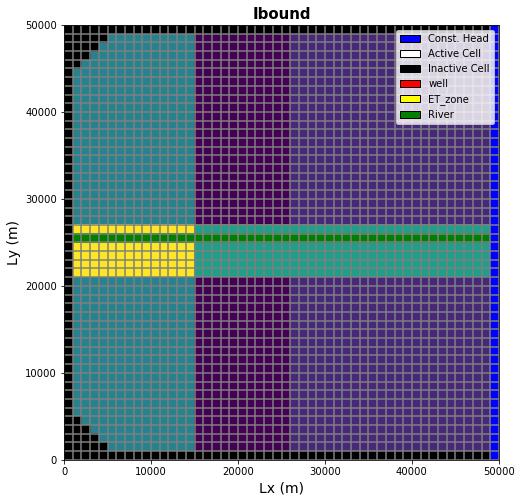

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(zones)
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
#quadmesh = modelmap.plot_array(win_sq_array)
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound(ibound[0])



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    #mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

<ipython-input-11-16c85b833718>:22: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')


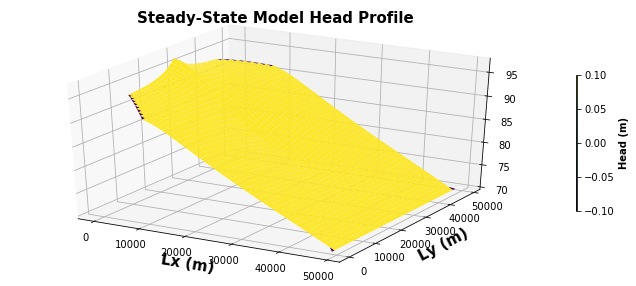

In [11]:

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#head = headobj.get_alldata()
head = headobj.get_alldata(nodata=-9.9998999e+02)
# print(head[0][0][27])
# print(head[0][1][27])
# print(head[0][2][27])

#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0][2])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=150).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

# plt.figure(figsize=(9,9)) #create 10 x 10 figure
# modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
# grid = modelmap.plot_grid() #plot model grid
# #riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
# #chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
# contour_levels = np.linspace(70,95,1) #set contour levels for contouring head
# head_contours = modelmap.contour_array(head[0][0], masked_values=[-1.0000000e+30], levels=contour_levels) #create head contours
# #flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
# #display parameters
# plt.xlabel('Lx (m)',fontsize = 14)
# plt.ylabel('Ly (m)',fontsize = 14)
# plt.title('Head', fontsize = 13, fontweight = 'bold')
# plt.colorbar(head_contours)
# plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
#                    mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
#                    mp.patches.Patch(color='white',label='Active Cell',ec='black')],
#                    bbox_to_anchor=(1.8,1.0)) #create legend
# plt.show(modelmap)    

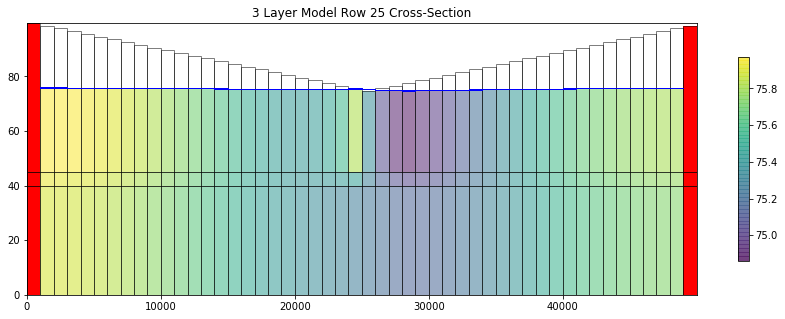

In [12]:
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#head = headobj.get_alldata()
head = headobj.get_alldata(nodata=-9.9998999e+02)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': well1_col}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
headpc = head[0]
pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head[0], color='blue', lw=1)

#print(head[0][0][1][:])

In [13]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps
#print(times)
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]]

#print(times2)



#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
#headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    #print(head)
# def evenorodd(a_list):
#     new_list=[]
#     for num in head:
#         if num==-9.9998999e+02:
#             new_list.append(70)
#         if not num==-9.9998999e+02:
#             new_list.append(num)
#     return new_list
# head= evenorodd(head['sp1'])
# print(head)
# print(head['sp1'])


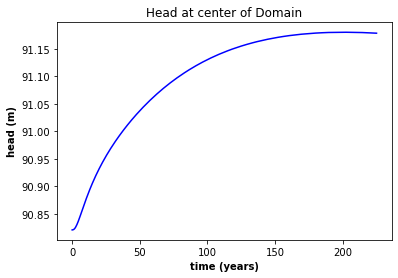

In [14]:
#head = headobj.get_alldata(nodata=-9.9998999e+02)
cell_id2 = (2, 36, 11) #cell at the center of the domain
time_series2 = headobj.get_ts(cell_id2) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at center of Domain")
#plt.title('Head at cell ({0},{1},{2})'.format(cell_id1[0] + 1, 
#                                              cell_id1[1] + 1, 
#                                              cell_id1[2] + 1),fontweight='bold') #create title with cell_id format
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0]/360, time_series2[:, 1], 'b-') #plot the time series with points at each record
plt.show()
#

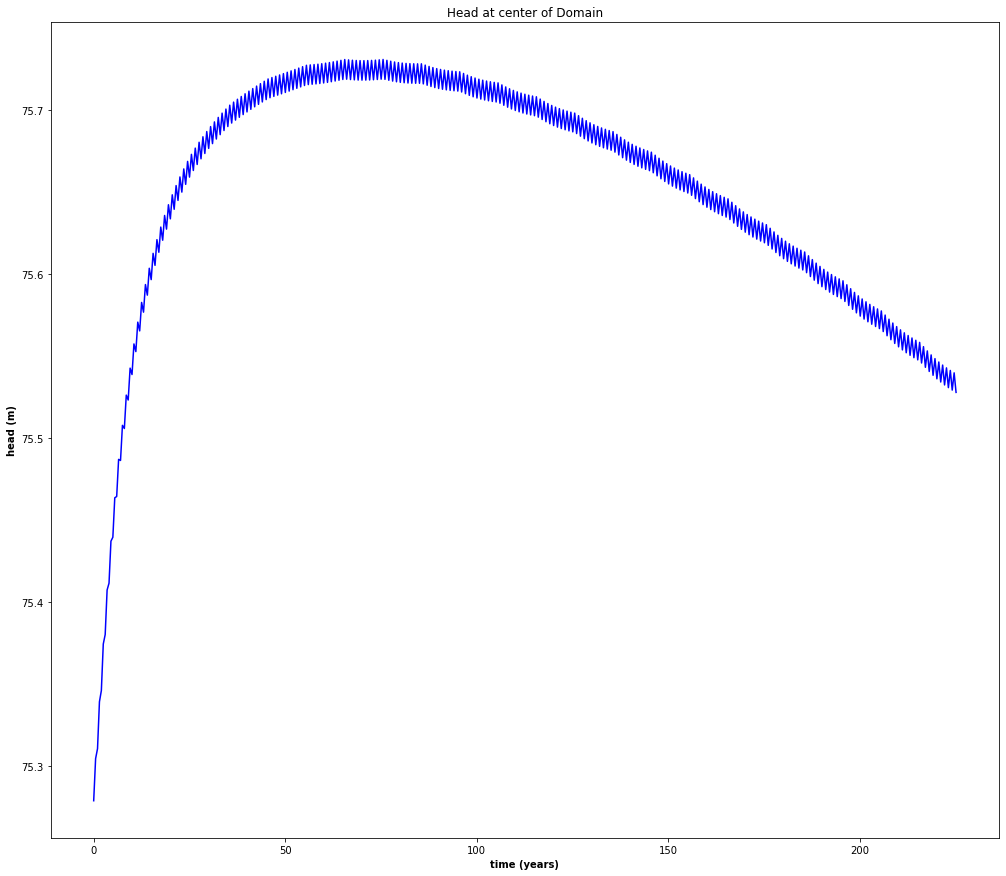

In [30]:
#head = headobj.get_alldata(nodata=-9.9998999e+02)
cell_id1 = (0, 29, 37) #cell at the center of the domain
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot 
plt.figure(figsize=(17,15))
# plt.subplot(1, 1, 1)
plt.title("Head at center of Domain")
#plt.title('Head at cell ({0},{1},{2})'.format(cell_id1[0] + 1, 
#                                              cell_id1[1] + 1, 
#                                          cell_id1[2] + 1),fontweight='bold') #create title with cell_id format

plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

In [16]:
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
leakage = budgobj.get_data(text='RIVER LEAKAGE',totim=time)
#print(leakage[0])
flux = np.array(range(nper))

for i in range(nper):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux = 0
    for k in range(len(leakage[:])):
        #print(leakage['sp%s'%i][0][k][1])
        #perflux = perflux + leakage['sp%s'%i][0][k][1]
        flux[i] = flux[i] + leakage[0][k][1]
    #print(perflux)
print(flux)    

[1500 1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513
 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527
 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541
 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555
 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569
 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583
 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597
 1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611
 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625
 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639
 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653
 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667
 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681
 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695
 1696 

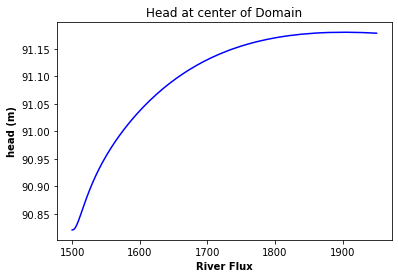

In [17]:
#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at center of Domain")
#plt.title('Head at cell ({0},{1},{2})'.format(cell_id1[0] + 1, 
#                                              cell_id1[1] + 1, 
#                                              cell_id1[2] + 1),fontweight='bold') #create title with cell_id format
plt.xlabel('River Flux',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(flux, time_series2[:, 1], 'b-') #plot the time series with points at each record
plt.show()
#